In [33]:
import random
import folium
import branca

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature

from cartopy.io import shapereader

pd.options.mode.chained_assignment = None 

# Funções

In [34]:
def string_para_float(numero):
    '''
    Transformação de colunas numéricas que utilizam indicador de milhar como '.'
    e decimal como ','
    '''
    numero = str(numero).replace('.', '')
    numero = numero.replace(',', '.')
    numero = float(numero)
    return numero

In [35]:
df_cad = pd.read_csv("./data/BD_Linhas-de-Transmissão(Cadastro).csv", encoding='latin-1', sep=';')
df_camp = pd.read_csv("./data/BD_Linhas-de-Transmissão(Campos).csv", encoding='latin-1', sep=';')
df_docs = pd.read_csv("./data/BD_Linhas-de-Transmissão(Documentos de Medição).csv", encoding='latin-1', sep=';')

In [36]:
df_campos_medicao = df_camp[['Planilha Documentos de Medição', 'Unnamed: 4']]
new_header = df_campos_medicao.iloc[0]
df_campos_medicao = df_campos_medicao[1:]
df_campos_medicao.columns = new_header

df_campos_medicao

0            Coluna                                  Significado
1       Equipamento                      Identificador do objeto
2     Ponto medição            Identificador do ponto de medição
3       Doc.medição        Identificador do documento de medição
4              Data                       Data do ensaio/medição
5      Item medição  Posição da estrutura onde é feita a medição
6     Valor teórico                       Valor teórico esperado
7     LimInfIntMed.                     Limite inferior esperado
8     LimSupIntMed.                     Limite superior esperado
9   ValMed/PosTCont                                 Valor medido
10   Unid.caracter.                           Unidade de medição
11  Cód.valorização                        Catálogo de respostas
12  Txt.code codif.                                     Resposta
13      Denominação              Denominação do ponto de medição
14            Texto                                  Comentários

In [37]:
df_campos_cadastro = df_camp[['Planilha Cadastro', 'Unnamed: 1']]

new_header = df_campos_cadastro.iloc[0]
df_campos_cadastro = df_campos_cadastro[1:-5]
df_campos_cadastro.columns = new_header

df_campos_cadastro

0                Coluna                            Significado
1           Equipamento                Identificador do objeto
2  Linha de Transmissão  Identificador da linha de transmissão
3           Denominação                    Descrição do objeto
4       Dt.entr.serviço            Data de entrada em operação
5                Classe                    Tipo do equipamento
6            Código ABC                            Criticidade
7                Tensão            Nível de tensão de operação
8              Latitude                    Latitude geográfica
9             Longitude                   Longitude geográfica

In [38]:
df_cad.head()

Equipamento Linha de Transmissão Denominação Dt.entr.serviço  \
0       115280                 LT31   Torre 111             NaN   
1       115281                 LT31   Torre 112             NaN   
2       115282                 LT31   Torre 113             NaN   
3       115283                 LT31   Torre 114             NaN   
4       115284                 LT31   Torre 115             NaN   

             Classe Código ABC  Tensão     Latitude    Longitude  
0  L_TORRE_AUTOPORT          C     230  -22,9776099  -50,0565232  
1  L_TORRE_AUTOPORT          C     230  -22,9791718  -50,0531681  
2  L_TORRE_AUTOPORT          C     230  -22,9808738  -50,0494992  
3  L_TORRE_AUTOPORT          C     230  -22,9830172  -50,0449193  
4  L_TORRE_AUTOPORT          C     230  -22,9846747  -50,0413489

In [39]:
aux = df_cad[['Equipamento', 'Linha de Transmissão']]
df_docs = df_docs.merge(aux, on='Equipamento')

df_docs['Ano'] = df_docs['Data'].apply(lambda x: x.split("/")[-1])


In [40]:
colunas_numericas = ['Valor teórico', 'LimInfIntMed.', 'LimSupIntMed.', 'ValMed/PosTCont']

for coluna in colunas_numericas:
    df_docs[coluna] = df_docs[coluna].apply(lambda x: string_para_float(x))

df_docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344285 entries, 0 to 344284
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Equipamento           344285 non-null  int64  
 1   Ponto medição         344285 non-null  int64  
 2   Doc.medição           344285 non-null  int64  
 3   Data                  344285 non-null  object 
 4   Item medição          344285 non-null  object 
 5   Valor teórico         249293 non-null  float64
 6   LimInfIntMed.         250954 non-null  float64
 7   LimSupIntMed.         249293 non-null  float64
 8   ValMed/PosTCont       343327 non-null  float64
 9   Unid.caracter.        344285 non-null  object 
 10  Cód.valorização       244269 non-null  float64
 11  Txt.code codif.       244269 non-null  object 
 12  Denominação           344285 non-null  object 
 13  Texto                 327656 non-null  object 
 14  Linha de Transmissão  344285 non-null  object 
 15  

In [41]:
# Transformação da coluna data para tipo Datetime
df_docs['Data'] = pd.to_datetime(df_docs['Data'], format='%d/%m/%Y')

In [42]:
df_qualif = df_docs[df_docs['Denominação'] == "Qualificacao do Equipamento"]
df_qualif.tail()

Equipamento  Ponto medição  Doc.medição       Data Item medição  \
344274       101273        4184986       805217 2019-01-31        TORRE   
344275       101273        4184986       592976 2018-10-05        TORRE   
344282       101272        4184861      4558054 2023-03-02        TORRE   
344283       101272        4184861      3347843 2021-08-24        TORRE   
344284       101272        4184861      3202488 2021-07-02        TORRE   

        Valor teórico  LimInfIntMed.  LimSupIntMed.  ValMed/PosTCont  \
344274            NaN            NaN            NaN              5.0   
344275            NaN            NaN            NaN              9.0   
344282            NaN            NaN            NaN              4.0   
344283            NaN            NaN            NaN              5.0   
344284            NaN            NaN            NaN              1.0   

       Unid.caracter.  Cód.valorização Txt.code codif.  \
344274             UN              NaN             NaN   
344275             UN              NaN             NaN   
344282             UN              NaN             NaN   
344283             UN              NaN             NaN   
344284             UN              NaN             NaN   

                        Denominação                                     Texto  \
344274  Qualificacao do Equipamento                                         9   
344275  Qualificacao do Equipamento                                       NaN   
344282  Qualificacao do Equipamento  FERRAGENS DE CONDUTOR:FERRAGEM E CONECTO   
344283  Qualificacao do Equipamento          D:0*1/ 0*2/ 0*3/ 0*4/ 2*5/ 165*9   
344284  Qualificacao do Equipamento  TEMPERATURA:CONEXAOD:1*1/ 0*2/ 0*3/ 0*4/   

       Linha de Transmissão   Ano  
344274               LT5203  2019  
344275               LT5203  2018  
344282               LT5203  2023  
344283               LT5203  2021  
344284               LT5203  2021

In [43]:
df_medicoes = df_docs[df_docs['Denominação'] != "Qualificacao do Equipamento"]
df_medicoes.tail()

Equipamento  Ponto medição  Doc.medição       Data  \
344277       101272        4184755      3344707 2021-08-23   
344278       101272        4184755      3200735 2021-07-02   
344279       101272        6506812      5970990 2023-11-09   
344280       101272        6506812      5970837 2023-11-09   
344281       101272        6506812      4557687 2023-01-24   

                Item medição  Valor teórico  LimInfIntMed.  LimSupIntMed.  \
344277         CABO CONDUTOR           75.0            0.0          999.0   
344278         CABO CONDUTOR           75.0            0.0          999.0   
344279  FERRAGENS DE CONDUTO            0.0            0.0            6.0   
344280  FERRAGENS DE CONDUTO            0.0            0.0            6.0   
344281  FERRAGENS DE CONDUTO            0.0            0.0            6.0   

        ValMed/PosTCont Unid.caracter.  Cód.valorização  \
344277              0.0             °C              1.0   
344278            126.0             °C              2.0   
344279              0.0             UN             10.0   
344280              0.0             UN             10.0   
344281              1.0             UN             11.0   

                       Txt.code codif.                          Denominação  \
344277                 CONDIÇÃO NORMAL     TEMP-INF/DIR/EXTER(CIRC DIR/UNI)   
344278                         CONEXAO     TEMP-INF/DIR/EXTER(CIRC DIR/UNI)   
344279                 CONDIÇÃO NORMAL  FERRAGENS/CONECTORES CONDUTOR (ESQ)   
344280                 CONDIÇÃO NORMAL  FERRAGENS/CONECTORES CONDUTOR (ESQ)   
344281  PARAFUSO/PORCA FALTANDO/FROUXO  FERRAGENS/CONECTORES CONDUTOR (ESQ)   

       Texto Linha de Transmissão   Ano  
344277     5               LT5203  2021  
344278     1               LT5203  2021  
344279     5               LT5203  2023  
344280   NaN               LT5203  2023  
344281     4               LT5203  2023

# Analise Exploratoria

In [44]:
df_cad['Latitude'] = df_cad['Latitude'].apply(lambda x: x.replace(',', '.'))
df_cad['Longitude'] = df_cad['Longitude'].apply(lambda x: x.replace(',', '.'))

df_cad['Latitude'] = pd.to_numeric(df_cad['Latitude'], errors='coerce')
df_cad['Longitude'] = pd.to_numeric(df_cad['Longitude'], errors='coerce')

In [45]:
from branca.element import Figure
fig = Figure(width=600, height=400)

df = df_cad[~df_cad['Latitude'].isna()]

grupos = df.groupby('Linha de Transmissão')

colors = {}

m = folium.Map(location=([-23.533773, -46.625290]))
# folium.TileLayer('cartodbdark_matter').add_to(m)

for nome_linha, grupo in list(grupos)[:80]:
    grupo = grupo.reset_index(drop=True)

    if nome_linha not in colors:
        colors[nome_linha] =  f"#{random.randint(0, 0xFFFFFF):06x}"
    
    for idx in range(1, len(grupo)):

        origin = grupo.loc[idx-1, :]
        destination = grupo.loc[idx, :]

        folium.CircleMarker([origin['Latitude'], origin['Longitude']],
                        radius=2, color=colors[nome_linha],
                        fill_color=colors[nome_linha], # divvy color
                       ).add_to(m)

    folium.CircleMarker([destination['Latitude'], destination['Longitude']],
                        radius=2, color=colors[nome_linha],
                        fill_color=colors[nome_linha], # divvy color
                    ).add_to(m)

fig.add_child(m)

In [46]:
denominacao_map = {
    "CORRO.": "CORROSÃO",
    "CORROSAO": "CORROSÃO",
    "CORROS": "CORROSÃO",
    "ISOL": "ISOL",
    "ESPACADOR": "ESPAÇADOR",
    "RABICHO": "RABICHO",
    "PECAS": "PEÇAS",
    "PECA": "PEÇAS",
    "ROCADA": "ROÇADA",
    "PARA-RAIO": "PARA-RAIO",
    "FERRAGENS": "FERRAGENS",
    "FERRAG": "FERRAGENS",
    "CABO CONDUTOR": "CABO CONDUTOR",
    "ESFERA": "ESFERA",
    "TENTO ROMPIDO": "TENTO ROMPIDO",
    "TENTO": "TENTO ROMPIDO",
    "AMORTECEDOR CONDUTOR": "AMORTECEDOR CONDUTOR",
    "JUMPER": "JUMPER",
    "EMENDA": "EMENDA",
    "TEMP": "TEMP",
    "GRAMPO DE SUSPENSAO CONDUTOR": "GRAMPO DE SUSPENSAO CONDUTOR",
    "BOBINA DE BLOQUEIO": "BOBINA DE BLOQUEIO",
    "CARGA RUPTURA": "CARGA RUPTURA",
    "GRAMPO DE ANCORAGEM CONDUTOR": "GRAMPO DE ANCORAGEM CONDUTOR",
    "PROTEÇÃO": "PROTEÇÃO (CHIFRE / ANEL)",
}

def process_denominacao(x):
    for key in denominacao_map:
        if key in x:
            return denominacao_map[key].upper()
    return x.upper()

df_medicoes['denominação_processed'] = df_medicoes['Denominação'].apply(lambda x: process_denominacao(x))

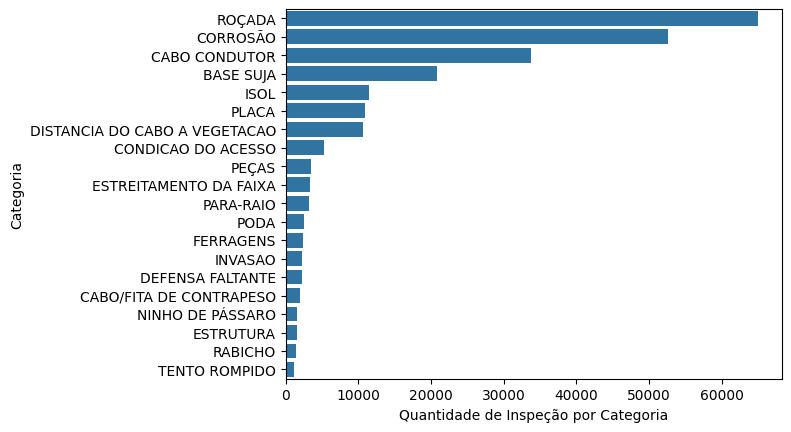

In [47]:
aux_data = df_medicoes['denominação_processed'].value_counts()[:20]

plt.title("")

sns.barplot(
    y=aux_data.index,
    x=aux_data.values, orient='h'
)

plt.xlabel("Quantidade de Inspeção por Categoria")
plt.ylabel("Categoria")
plt.show()

In [48]:
def convert_str_to_number(x):
    if isinstance(x, str):
        return float(x.replace('.', '').replace(',', '.'))
    return x
    

df_medicoes['ValMed/PosTCont'] = df_medicoes['ValMed/PosTCont'].apply(lambda x: convert_str_to_number(x))
df_medicoes['LimInfIntMed.'] = df_medicoes['LimInfIntMed.'].apply(lambda x: convert_str_to_number(x))
df_medicoes['LimSupIntMed.'] = df_medicoes['LimSupIntMed.'].apply(lambda x: convert_str_to_number(x))


df_medicoes['inside_limit'] = (df_medicoes['ValMed/PosTCont'] >= df_medicoes['LimInfIntMed.']) & (df_medicoes['ValMed/PosTCont'] <= df_medicoes['LimSupIntMed.'])
df_medicoes['deviation'] = df_medicoes['ValMed/PosTCont'] - ((df_medicoes['LimInfIntMed.'] + df_medicoes['LimSupIntMed.'])/2)

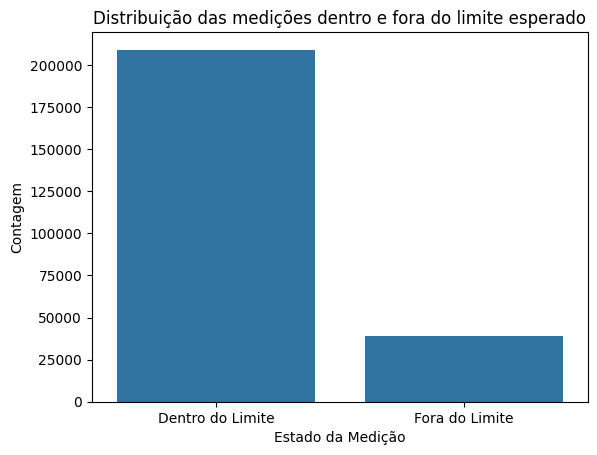

In [49]:
aux_counts = df_medicoes['inside_limit'].value_counts()
replace_ = {True: 'Dentro do Limite', False: 'Fora do Limite'}

sns.barplot(
    x=[replace_[i] for i in aux_counts.index],
    y=aux_counts.values
)
plt.ylabel("Contagem")
plt.xlabel("Estado da Medição")
plt.title("Distribuição das medições dentro e fora do limite esperado")
plt.show()

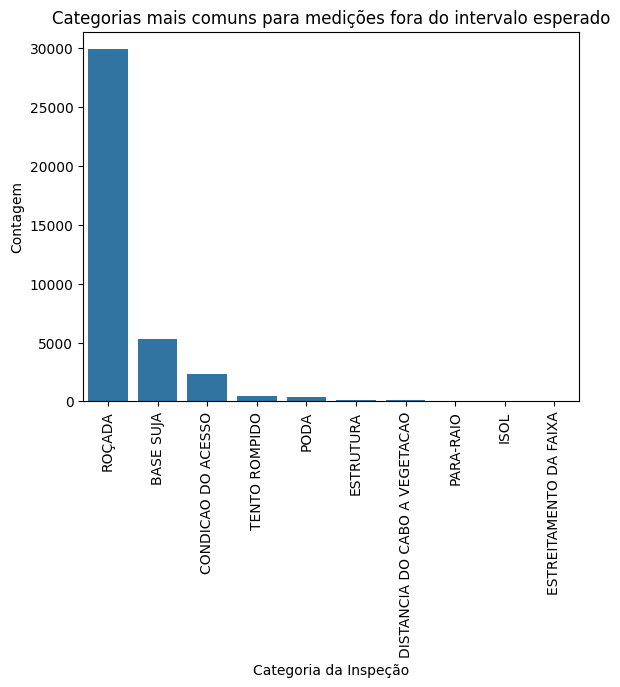

In [50]:
out_limit  = df_medicoes[df_medicoes['inside_limit'] == False]

counts_aux = out_limit['denominação_processed'].value_counts()

sns.barplot(
    x=counts_aux.index[:10],
    y=counts_aux.values[:10]
)
plt.xticks(rotation=90)
plt.ylabel("Contagem")
plt.xlabel("Categoria da Inspeção")
plt.title("Categorias mais comuns para medições fora do intervalo esperado")
plt.show()

In [51]:
aux_df_docs = df_medicoes[df_medicoes['denominação_processed'] != 'QUALIFICACAO DO EQUIPAMENTO']
# aux_df_docs  = aux_df_docs[aux_df_docs['inside_limit'] == False]


inspecoes_motivo = aux_df_docs.groupby('Equipamento', as_index = False)['denominação_processed'].agg(pd.Series.mode)
inspecoes = aux_df_docs.groupby('Equipamento', as_index = False)['denominação_processed'].count()
anos = aux_df_docs.groupby('Equipamento', as_index = False)['Ano'].nunique()

# df_cad.merge()
inspecoes = inspecoes.merge(anos, on='Equipamento')
inspecoes['Taxa'] = inspecoes["denominação_processed"]/inspecoes['Ano']

inspecoes['count_Denominação'] = inspecoes['denominação_processed']
del inspecoes['denominação_processed']

aux_cad = df_cad.merge(inspecoes, on='Equipamento')
aux_cad = aux_cad.merge(inspecoes_motivo, on='Equipamento')


aux_cad['above_threshold'] = aux_cad['Taxa'] > 6

fig = Figure(width=1200, height=1000)

df = aux_cad[~aux_cad['Latitude'].isna()]
df = df[df['above_threshold'] == True]

grupos = df.groupby('Linha de Transmissão')

colors = {
}

m = folium.Map(location=([-23.533773, -46.625290]))
folium.TileLayer('Cartodb Positron').add_to(m)

for nome_linha, grupo in list(grupos)[:]:
    grupo = grupo.reset_index(drop=True)


    for idx in range(0, len(grupo)):

        origin = grupo.loc[idx, :]

        if isinstance(origin['denominação_processed'], str):
            if origin['denominação_processed'] not in colors:
                colors[origin['denominação_processed']] =  f"#{random.randint(0, 0xFFFFFF):06x}"

            folium.CircleMarker([origin['Latitude'], origin['Longitude']],
                radius=3, color=colors[origin['denominação_processed']],
                fill_color=colors[origin['denominação_processed']],
                popup=origin['denominação_processed'], fill=True
            ).add_to(m)
        
        else:
            if origin['denominação_processed'][-1] not in colors:
                colors[origin['denominação_processed'][-1]] =  f"#{random.randint(0, 0xFFFFFF):06x}"

            folium.CircleMarker([origin['Latitude'], origin['Longitude']],
                radius=3, color=colors[origin['denominação_processed'][-1]],
                fill_color=colors[origin['denominação_processed'][-1]],
                popup=origin['denominação_processed'], fill=True
            ).add_to(m)

       

legends = [f'&nbsp; <i class="fa fa-circle" style="color:{colors[i]}"></i> {i} &nbsp; <br>' for i in sorted(colors)[:21]]

legend_html = '''
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 300px; height: 350px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 0.85;">
     &nbsp; <b>Legend</b> <br>'''+" ".join(legends)+'''     
</div>
{% endmacro %}
'''

legend = branca.element.MacroElement()
legend._template = branca.element.Template(legend_html)


fig.add_child(m)
fig.add_child(legend)


m

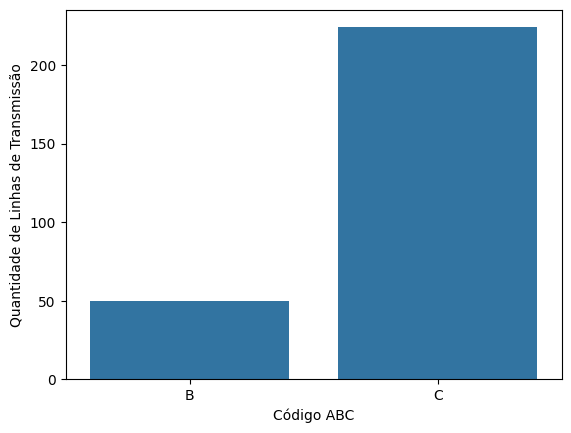

In [52]:
aux_data = df_cad.groupby('Código ABC')['Linha de Transmissão'].nunique()

sns.barplot(
    x=aux_data.index,
    y=aux_data.values
)
plt.ylabel("Quantidade de Linhas de Transmissão")
plt.show()

Text(0, 0.5, 'Proporção')

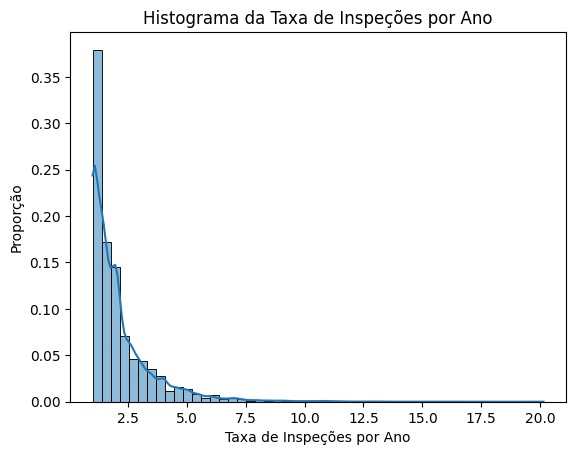

In [53]:
sns.histplot(
    x=inspecoes['Taxa'],
    stat="probability", common_norm=False,  bins=50, kde=True
)

plt.title("Histograma da Taxa de Inspeções por Ano")
plt.xlabel("Taxa de Inspeções por Ano")
plt.ylabel("Proporção")

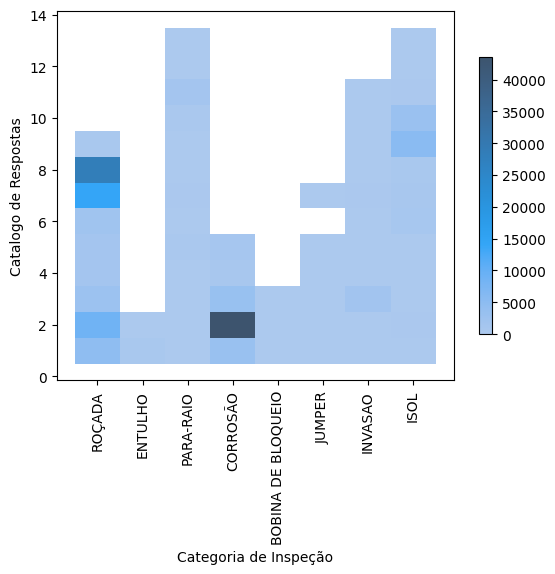

In [54]:
aux_df = df_medicoes[df_medicoes['denominação_processed'].isin(['ROÇADA', 'CORROSÃO', 'ENTULHO', 'ISOL', 'JUMPER', 'PARA-RAIO', 'INVASAO', 'BOBINA DE BLOQUEIO'])]

sns.histplot(
    x=aux_df['denominação_processed'],
    y=aux_df['Cód.valorização'], discrete=(True, True),
    cbar=True, cbar_kws=dict(shrink=.75),
)
plt.xticks(rotation=90)
plt.xlabel("Categoria de Inspeção")
plt.ylabel("Catalogo de Respostas")
plt.show()

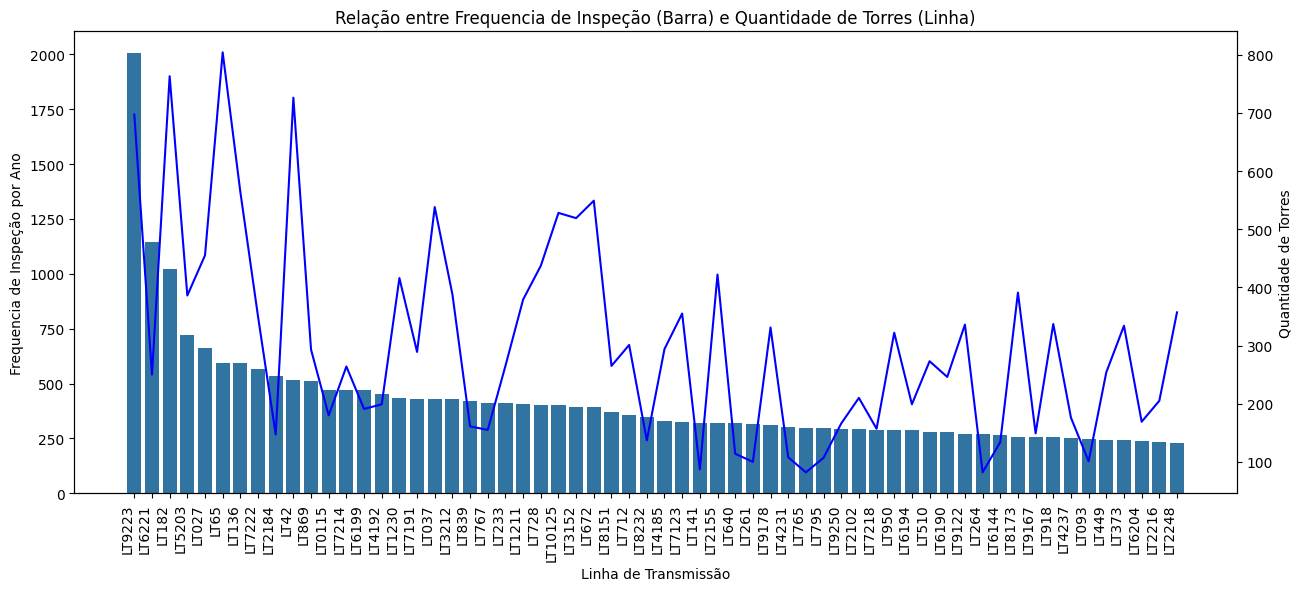

In [55]:

aux_data = (df_docs.groupby('Linha de Transmissão')['Denominação'].count()/df_docs.groupby('Linha de Transmissão')['Ano'].nunique()).sort_values(ascending=False)[:60]

aux_cad = df_cad[df_cad['Linha de Transmissão'].isin(aux_data.index)]
aux_cad = aux_cad.groupby('Linha de Transmissão')['Equipamento'].nunique()

plt.figure(figsize=(15, 6))

sns.barplot(
    x=aux_data.index,
    y=aux_data.values
)

plt.title("Relação entre Frequencia de Inspeção (Barra) e Quantidade de Torres (Linha)")

plt.ylabel("Frequencia de Inspeção por Ano")
plt.xticks(rotation=90, ha='right')

ax2 = plt.twinx()
sns.lineplot(x=aux_cad.index, y=aux_cad.values, color="b", ax=ax2, markers='x')
plt.ylabel("Quantidade de Torres")


plt.show()


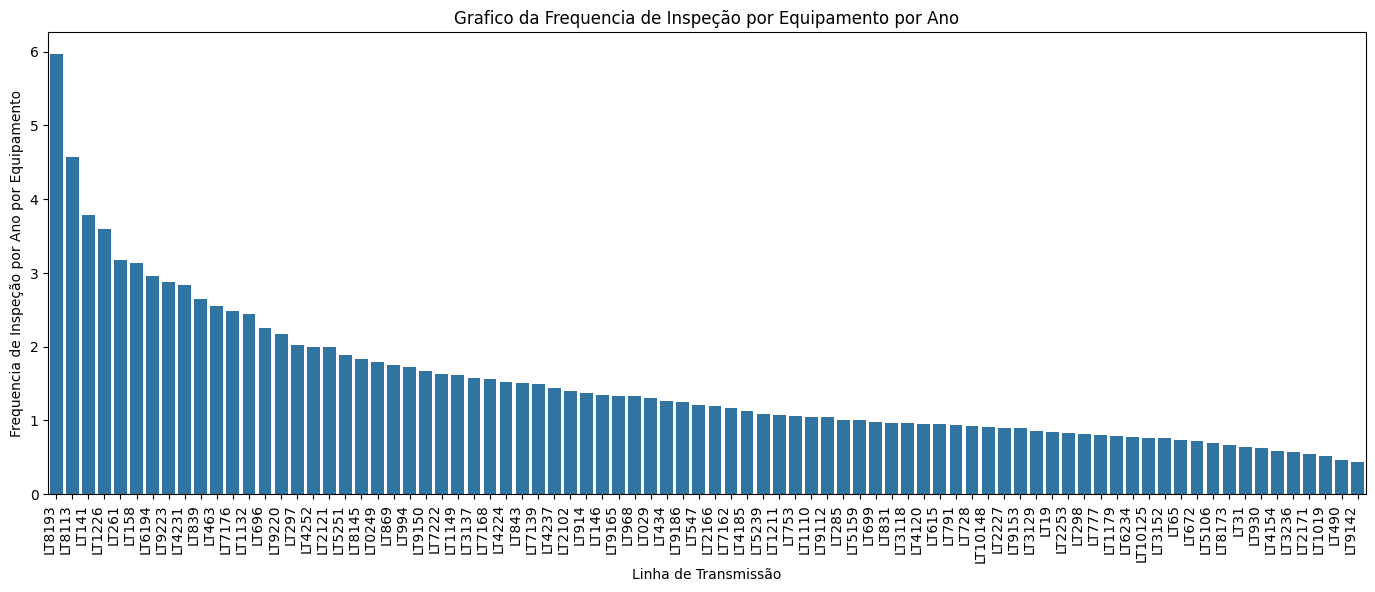

In [56]:

aux_data = (df_docs.groupby('Linha de Transmissão')['Denominação'].count()/df_docs.groupby('Linha de Transmissão')['Ano'].nunique()/df_docs.groupby('Linha de Transmissão')['Equipamento'].nunique()).sort_values(ascending=False)[::3]

plt.figure(figsize=(17, 6))

sns.barplot(
    x=aux_data.index,
    y=aux_data.values
)

plt.title("Grafico da Frequencia de Inspeção por Equipamento por Ano")

plt.ylabel("Frequencia de Inspeção por Ano por Equipamento")
plt.xticks(rotation=90, ha='right')


plt.show()


## Contagem de medições por dia

<Axes: xlabel='Data', ylabel='Equipamento'>

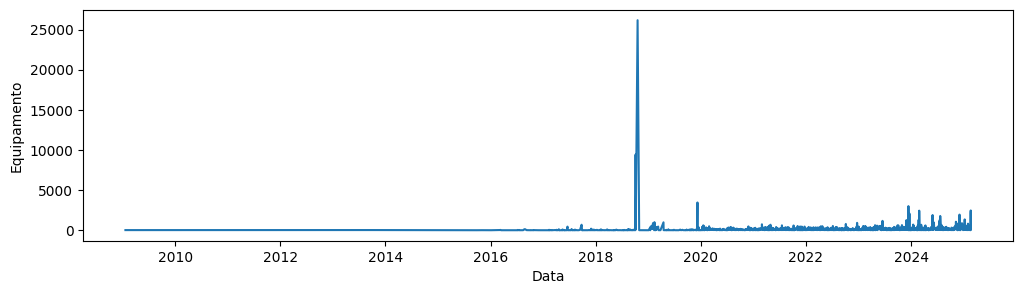

In [57]:
fig, ax = plt.subplots(figsize=(12,3))
sns.lineplot(df_docs.groupby('Data')['Equipamento'].count(), ax=ax)

In [58]:
print('Dia com maior número de medições:')
df_docs.groupby('Data')[['Equipamento']].count().sort_values(by='Equipamento', ascending=False).head(1)

Dia com maior número de medições:


Equipamento
Data                   
2018-10-19        26162

<Axes: xlabel='Ano', ylabel='Ano'>

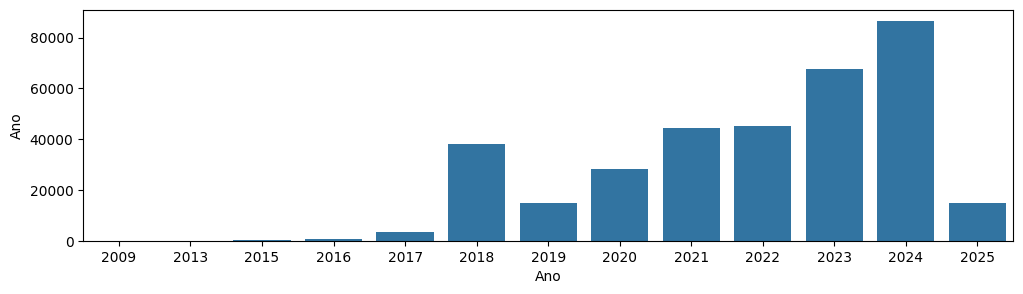

In [59]:
fig, ax = plt.subplots(figsize=(12,3))
sns.barplot(df_docs.groupby('Ano')['Ano'].count(), ax=ax)

In [60]:
colunas_numericas = ['Valor teórico', 'LimInfIntMed.', 'LimSupIntMed.', 'ValMed/PosTCont']

for coluna in colunas_numericas:
    df_docs[coluna] = df_docs[coluna].apply(lambda x: string_para_float(x))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344285 entries, 0 to 344284
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Equipamento           344285 non-null  int64         
 1   Ponto medição         344285 non-null  int64         
 2   Doc.medição           344285 non-null  int64         
 3   Data                  344285 non-null  datetime64[ns]
 4   Item medição          344285 non-null  object        
 5   Valor teórico         249293 non-null  float64       
 6   LimInfIntMed.         250954 non-null  float64       
 7   LimSupIntMed.         249293 non-null  float64       
 8   ValMed/PosTCont       343327 non-null  float64       
 9   Unid.caracter.        344285 non-null  object        
 10  Cód.valorização       244269 non-null  float64       
 11  Txt.code codif.       244269 non-null  object        
 12  Denominação           344285 non-null  object        
 13 

In [62]:
df_docs[colunas_numericas].describe()

Valor teórico  LimInfIntMed.  LimSupIntMed.  ValMed/PosTCont
count  249293.000000       250954.0  249293.000000     3.433270e+05
mean        7.495598            0.0     877.095265     1.251334e+04
std        48.286623            0.0    1104.606494     7.376119e+05
min         0.000000            0.0      20.000000    -2.500000e+02
25%         0.000000            0.0     990.000000     1.000000e+01
50%         0.000000            0.0     990.000000     4.000000e+01
75%         0.000000            0.0    1000.000000     9.000000e+01
max      1000.000000            0.0    9990.000000     9.719449e+07

In [63]:
# amostra de equipamentos com Valor Medido > 1E6
df_docs[df_docs['ValMed/PosTCont']> 1e6].head()

Equipamento  Ponto medição  Doc.medição       Data   Item medição  \
21302        121217        6902891      2921514 2021-03-28            VÃO   
70655        115582        6377007      7500069 2024-11-08            VÃO   
71771        115436        6351948      4912916 2023-05-17            VÃO   
78734        106492        6156515      5971536 2023-10-27            VÃO   
135994       104886         938950      7129022 2024-08-12  CABO CONDUTOR   

        Valor teórico  LimInfIntMed.  LimSupIntMed.  ValMed/PosTCont  \
21302             0.0            0.0         1000.0        1655600.0   
70655             0.0            0.0         1000.0        1347500.0   
71771             0.0            0.0         1000.0        1400000.0   
78734             0.0            0.0         1000.0        1140000.0   
135994            0.0            0.0           60.0        9389500.0   

       Unid.caracter.  Cód.valorização Txt.code codif.  \
21302              m2              7.0    VAO COMPLETO   
70655              m2              7.0    VAO COMPLETO   
71771              m2              7.0    VAO COMPLETO   
78734              m2              7.0    VAO COMPLETO   
135994             UN              NaN             NaN   

                                    Denominação Texto Linha de Transmissão  \
21302                         ROCADA MECANIZADA     4                 LT42   
70655                         ROCADA MECANIZADA     4                LT449   
71771                             ROCADA MANUAL     4                LT449   
78734                             ROCADA MANUAL     4                LT152   
135994  CORROSAO AMORTECEDOR CONDUTOR (DIR/UNI)     9                LT791   

         Ano  
21302   2021  
70655   2024  
71771   2023  
78734   2023  
135994  2024

In [64]:
# linha do tempo para um equiapmento
df_docs[df_docs['Equipamento'] == 305964].sort_values(by='Data')

Equipamento  Ponto medição  Doc.medição       Data  \
144377       305964        9700196      4520207 2023-02-11   
144376       305964        9700196      6332318 2024-02-28   
144374       305964        9700212      6582831 2024-04-22   
144375       305964        9700212      6582830 2024-04-22   
144373       305964        9700212      6735738 2024-05-27   

                Item medição  Valor teórico  LimInfIntMed.  LimSupIntMed.  \
144377                 TORRE           50.0            0.0           50.0   
144376                 TORRE           50.0            0.0           50.0   
144374  SISTAMA DE ATERRAMEN            0.0            0.0          990.0   
144375  SISTAMA DE ATERRAMEN            0.0            0.0          990.0   
144373  SISTAMA DE ATERRAMEN            0.0            0.0          990.0   

        ValMed/PosTCont Unid.caracter.  Cód.valorização  Txt.code codif.  \
144377             50.0             UN              NaN              NaN   
144376             50.0             UN              NaN              NaN   
144374       97002120.0             UN              7.0  CONDIÇÃO NORMAL   
144375       97002120.0             UN              7.0  CONDIÇÃO NORMAL   
144373              NaN             UN              7.0  CONDIÇÃO NORMAL   

                        Denominação                             Texto  \
144377  Qualificacao do Equipamento  D:0*1/ 0*2/ 0*3/ 0*4/ 1*5/ 166*9   
144376  Qualificacao do Equipamento  D:0*1/ 0*2/ 0*3/ 0*4/ 2*5/ 165*9   
144374      CABO/FITA DE CONTRAPESO                               NaN   
144375      CABO/FITA DE CONTRAPESO                               NaN   
144373      CABO/FITA DE CONTRAPESO                                 5   

       Linha de Transmissão   Ano  
144377               LT1110  2023  
144376               LT1110  2024  
144374               LT1110  2024  
144375               LT1110  2024  
144373               LT1110  2024